# Differential Gene Expression Analysis of Acute Myeloid Leukemia and Acute Lymphoblastics Leukemia

## Objective
This analysis is a part of the secondary aim of this analysis project to understand the gene expression differences between two leukemia classes: Acute Myeloid Leukemia (AML) and Acute Lymphoblastics Leukemia (ALL).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

## Importing data and preprocessing

In [2]:
trainData = pd.read_csv("/Users/maitreepatel/Desktop/microarrayCancerPrediction/data_set_ALL_AML_train.csv")
testData = pd.read_csv("/Users/maitreepatel/Desktop/microarrayCancerPrediction/data_set_ALL_AML_independent.csv")

# Removing columns with "call.x"
# From training data
colsToRemoveTrain = [cols for cols in trainData if 'call' in cols]
trainData = trainData.drop(colsToRemoveTrain, axis=1)

# Removing from test data
colsToRemoveTest = [cols for cols in testData if 'call' in cols]
testData = testData.drop(colsToRemoveTest, axis=1)

# Since we are classifying patients (i.e. AML versus ALL) and predicting using gene expression,
# We transpose the data
X_train = trainData.transpose()
X_test = testData.transpose()

# Since both gene description and accession are now column-wise,
# setting accessing as columns and removing the gene description
X_train.columns = X_train.iloc[1]
X_train = X_train.iloc[2:].reset_index(drop=True)

X_test.columns = X_test.iloc[1]
X_test = X_test.iloc[2:].reset_index(drop=True)

countsData = pd.concat([X_train, X_test], ignore_index=True, axis=0)
affymetricProbeCols = [cols for cols in countsData if 'AFFX' in cols]
countsData = countsData.drop(affymetricProbeCols, axis=1)
countsData

Gene Accession Number,hum_alu_at,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,15091,151,72,281,36,-299,57,186,1647,137,...,185,511,-125,389,-37,793,329,36,191,-37
1,11038,263,21,250,43,-103,169,219,2043,188,...,169,837,-36,442,-17,782,295,11,76,-14
2,16692,88,-27,358,42,142,359,237,1997,91,...,315,1199,33,168,52,1138,777,41,228,-41
3,15763,484,61,118,39,-11,274,245,2128,-82,...,240,835,218,174,-110,627,170,-50,126,-91
4,18128,118,16,197,39,237,311,186,1608,204,...,156,649,57,504,-26,250,314,14,56,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,22818,316,0,105,104,-76,38,261,1397,60,...,92,532,-34,239,-78,707,354,-22,260,5
68,39323,228,36,106,113,19,141,165,1030,73,...,63,297,36,358,2,423,41,0,1777,-49
69,15689,395,73,334,73,417,259,359,2656,318,...,130,639,-27,548,-39,809,445,-2,210,16
70,41570,311,-56,235,46,845,168,517,3570,92,...,84,1141,-121,197,-108,466,349,0,284,-73


In [3]:
metadata = pd.read_csv("/Users/maitreepatel/Desktop/microarrayCancerPrediction/actual.csv")
metadata.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


## Data QC and exploration

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

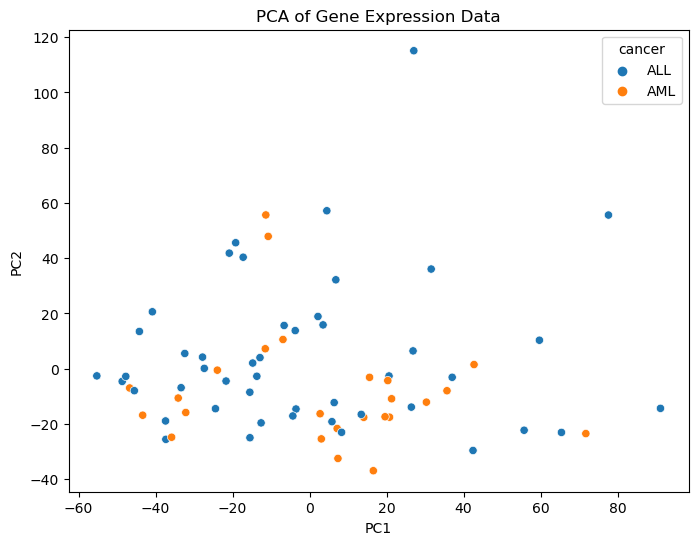

In [5]:
# PCA for QC
scaler = StandardScaler()
countsData_scaled = scaler.fit_transform(countsData)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(countsData_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cancer'] = metadata['cancer']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cancer', data=pca_df)
plt.title('PCA of Gene Expression Data')
plt.show()

### Exploring distribution of gene expression
#### Total counts per Sample

In [7]:
# calcualte total counts per sample and log transform counts
totalCounts = pd.DataFrame(countsData.sum(axis=1))
totalCounts

,0
0,4428725.0
1,4803225.0
2,4821731.0
3,4176333.0
4,4737152.0
...,...
67,3874752.0
68,3706273.0
69,5076164.0
70,4820610.0


<BarContainer object of 72 artists>

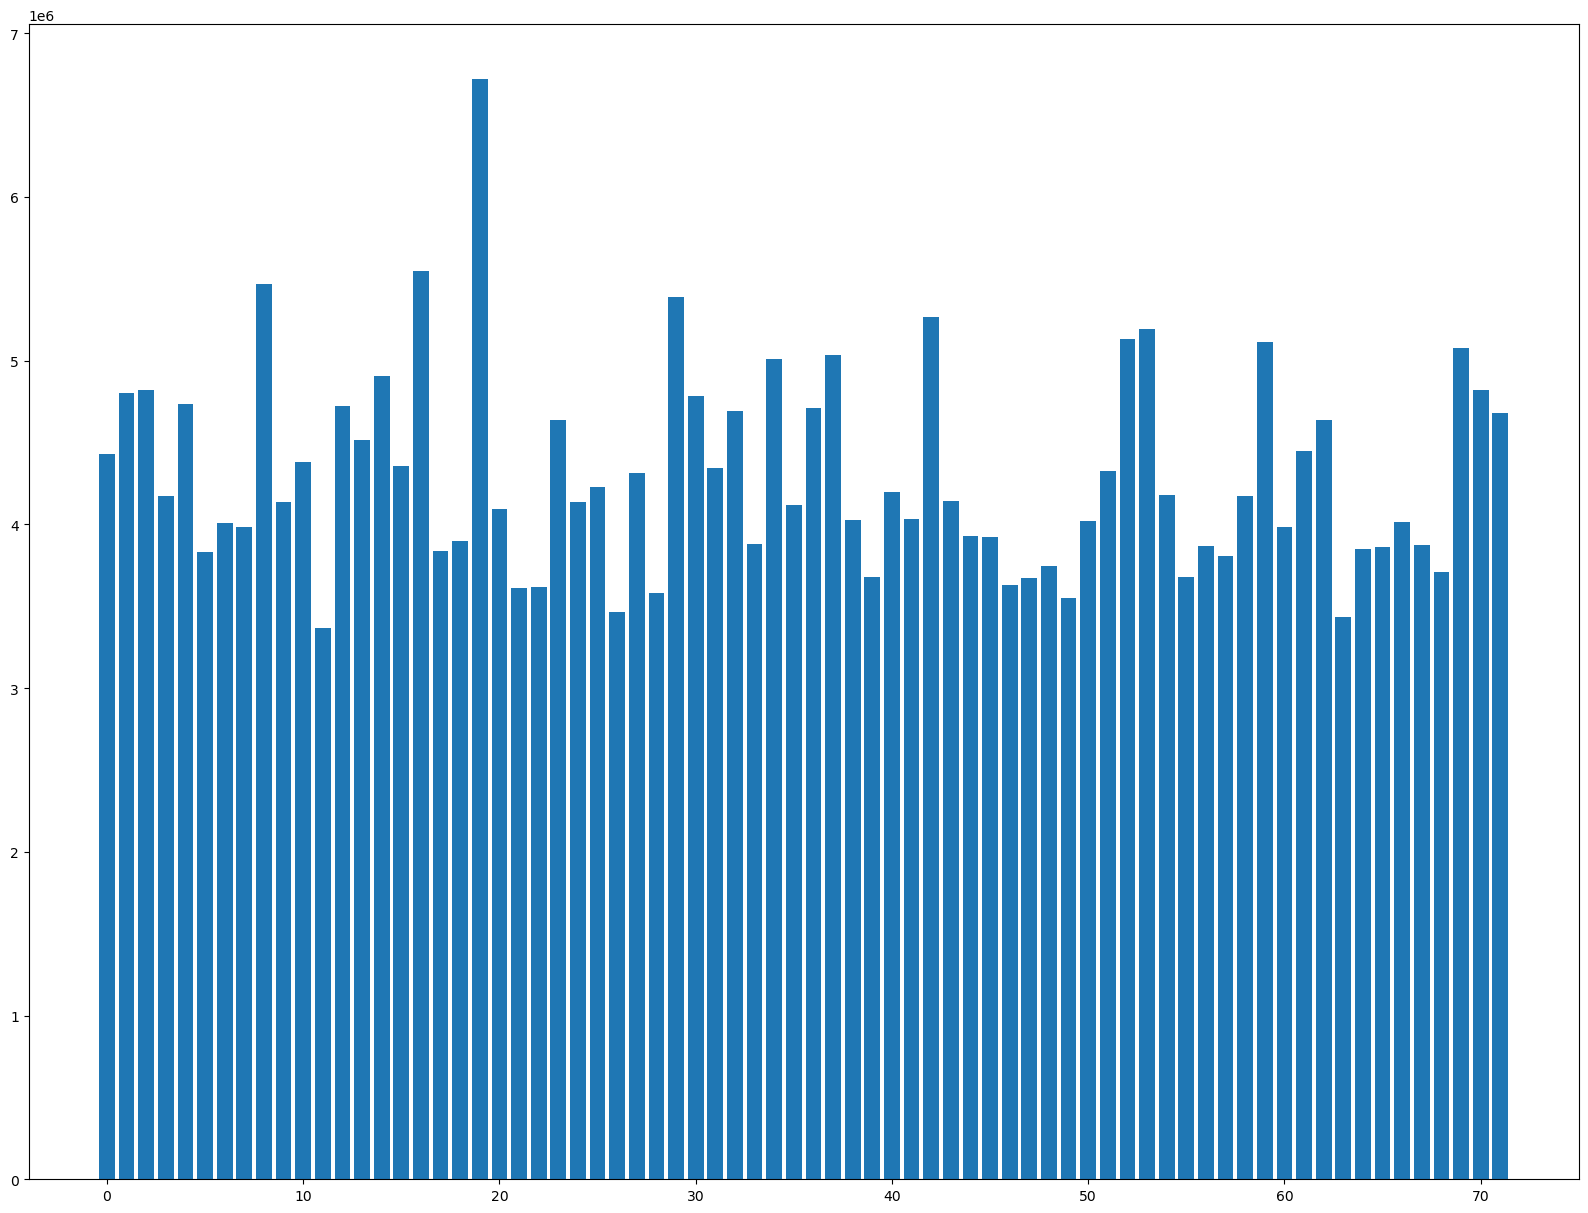

In [8]:
plt.figure(figsize=(20, 15))
plt.bar(totalCounts.index, totalCounts[0])

The folowing graph represents total counts per sample representing sequencing depth, this data shows variation in sequencing depth. Ideally, we would want amost equal sequencing depth across the samples.
#### Assesing variability in the counts data

In [9]:
from sklearn.preprocessing import StandardScaler

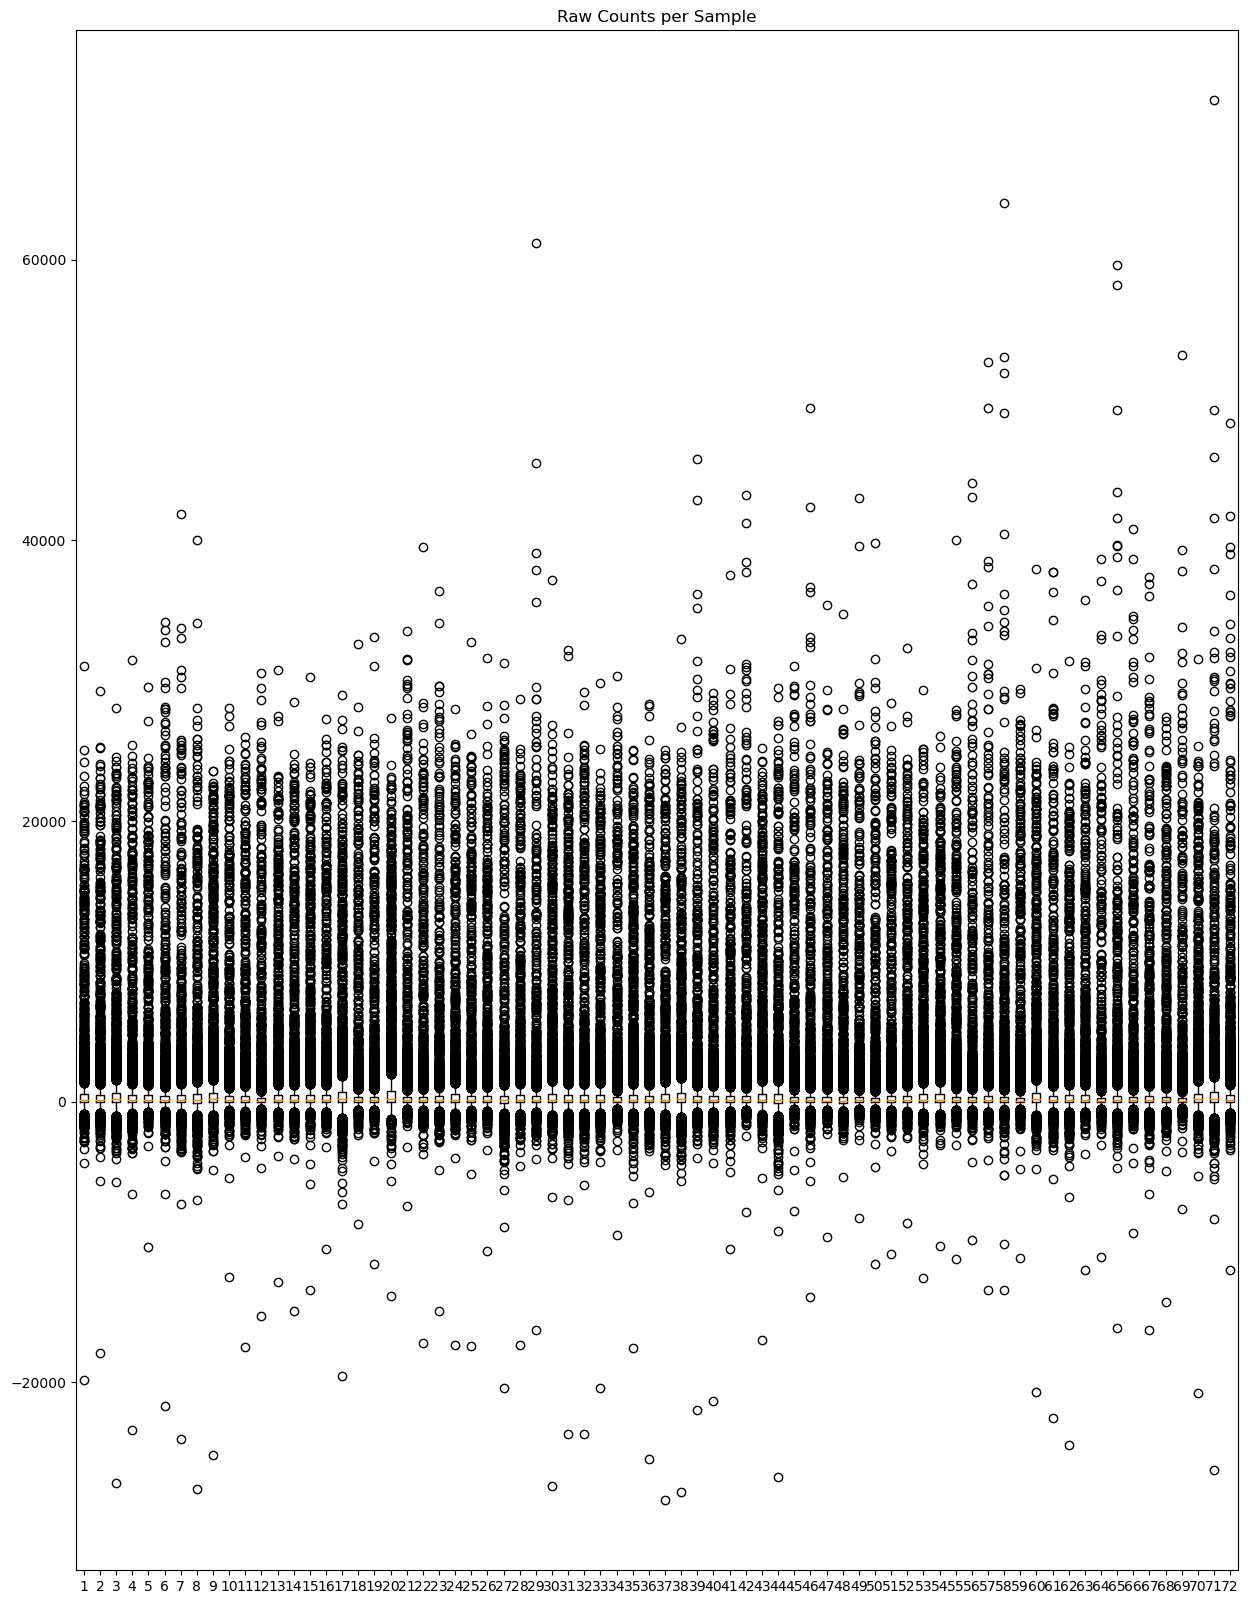

In [10]:
plt.figure(figsize=(15,20))
plt.boxplot(countsData.transpose())
plt.title("Raw Counts per Sample")
plt.show()

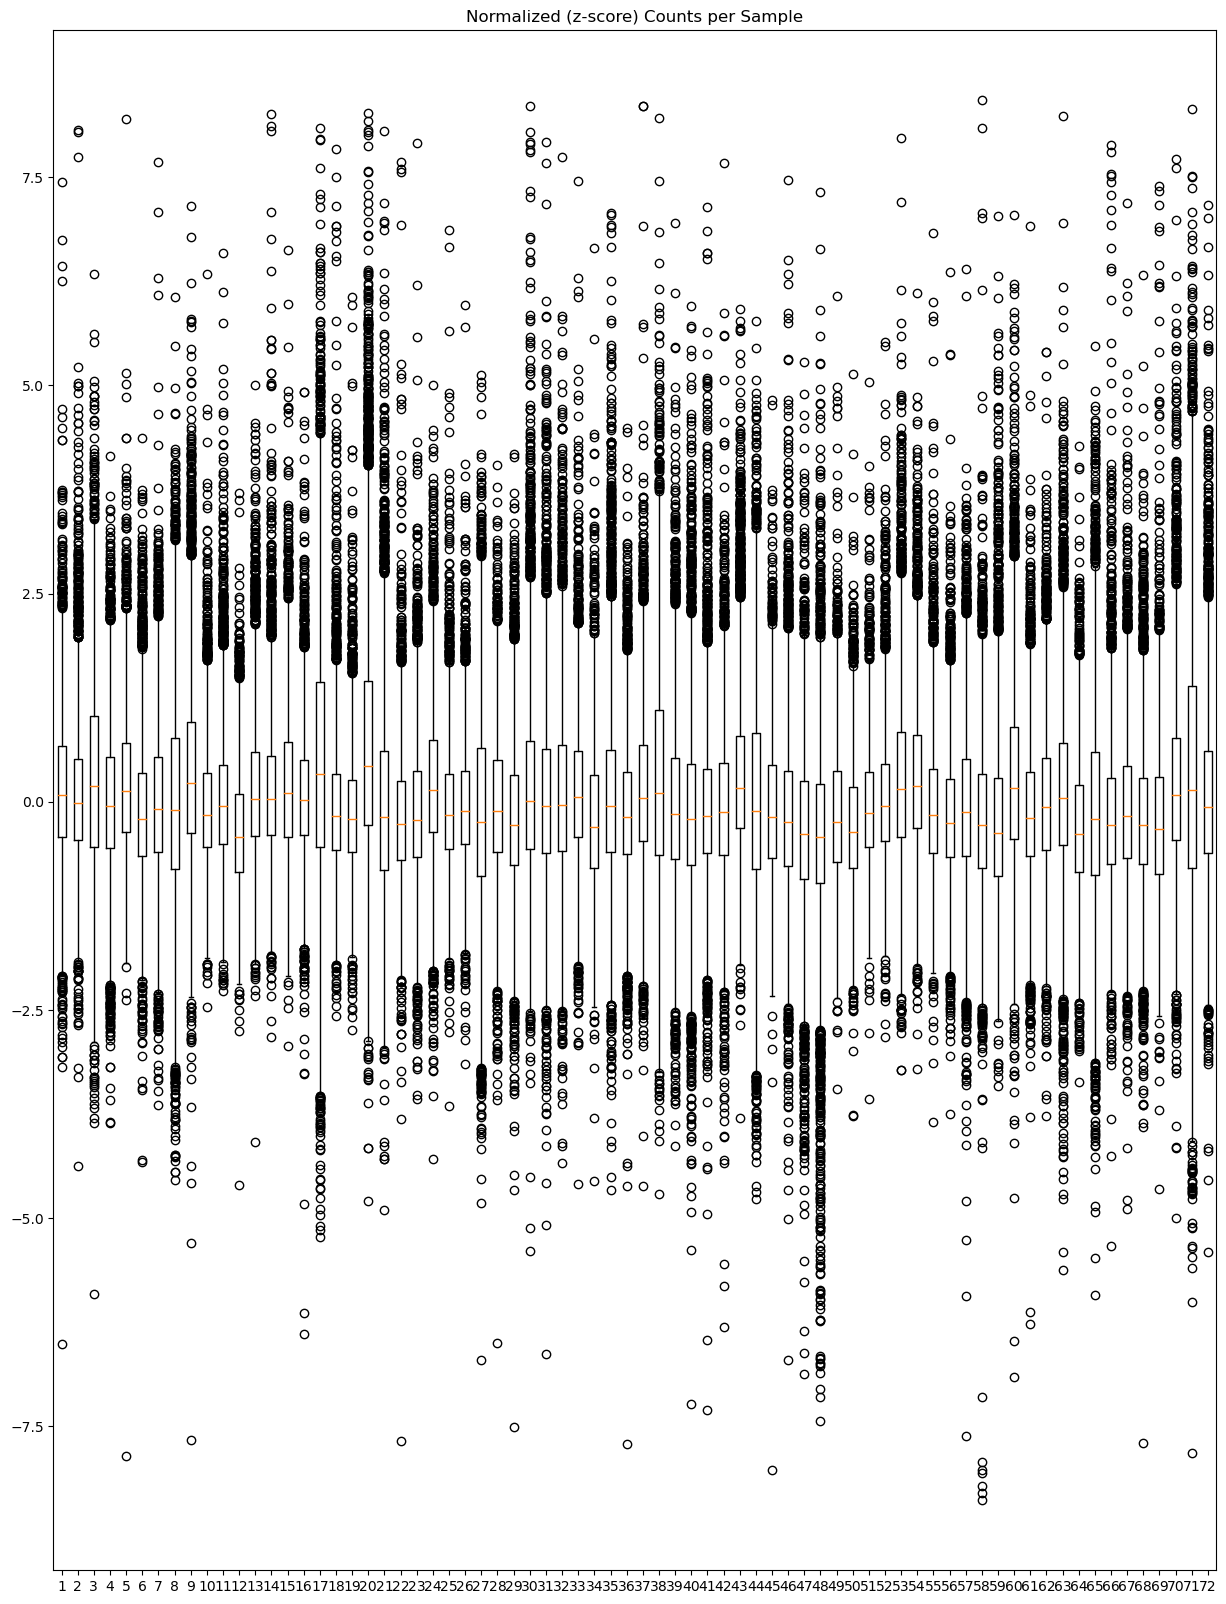

In [11]:
# Plotting normalized data
plt.figure(figsize=(15,20))
plt.boxplot(countsData_scaled.transpose())
plt.title("Normalized (z-score) Counts per Sample")
plt.show()

Interpretting above plots:
- **Highly variable counts values** with samples (after normalization)
- **Negative counts** data (before normalization)
    - Negative counts in microarray could have arisen due to preprocessing steps by the Golub et al 1999 study.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


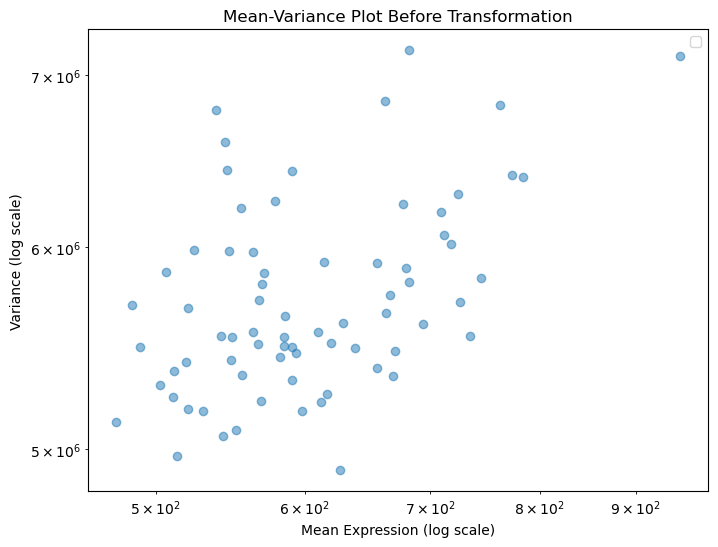

In [12]:
means = countsData.mean(axis=1)
variances = countsData.var(axis=1)

# Plot Mean-Variance relationship
plt.figure(figsize=(8, 6))
plt.scatter(means, variances, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean Expression (log scale)')
plt.ylabel('Variance (log scale)')
plt.title('Mean-Variance Plot Before Transformation')
plt.legend()
plt.show()

The mean-variance plot does not show a visible trend in the scatter of data points and indicates somewhat equal spread. Therefore variance is stabilized in the data and no correction was performed for this analysis.
#### Heirarchal clustering

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage

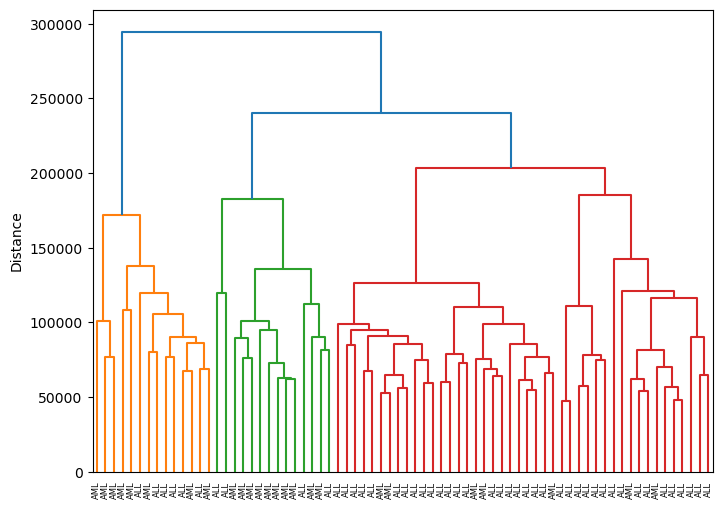

In [14]:
# perform hierarchical clustering and create dendrogram
h_clustering = linkage(countsData, 'ward')
plt.figure(figsize=(8, 6))
dendrogram(h_clustering, labels=metadata['cancer'].values)
plt.xticks(rotation=90)
plt.ylabel('Distance')
plt.show()

In [15]:
metadata

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL
...,...,...
67,68,ALL
68,69,ALL
69,70,ALL
70,71,ALL


In [16]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection

In [86]:
# First, Merging data
merged = pd.concat([countsData, metadata], ignore_index=True, axis=1)
# Splitting data into the two cancer classes
ALL = pd.DataFrame(countsData[merged.iloc[:,7072] == "ALL"])
AML = pd.DataFrame(countsData[merged.iloc[:,7072] == "AML"])
ALL = ALL.apply(pd.to_numeric, errors='coerce')
AML = AML.apply(pd.to_numeric, errors='coerce')
print(ALL.shape)
print(AML.shape)

(47, 7071)
(25, 7071)


In [26]:
resultsTTest = []

for gene in ALL.columns:
    t_stat, p_val = ttest_ind(ALL[gene], AML[gene], equal_var=False)  # Perform t-test
    resultsTTest.append((gene, t_stat, p_val))
    
dfResults = pd.DataFrame(resultsTTest, columns=['Gene Accession Number', 'T_Value', 'P_Value'])

# correcting for multiple testing
sig, adj_p_values = fdrcorrection(dfResults['P_Value'])
sigGenes = dfResults[sig & (adj_p_values < 0.05)]
sigGenes = sigGenes.sort_values(by='P_Value')
sigGenes

,Gene Accession Number,T_Value,P_Value
3242,U49248_at,5.074976,0.000004
4476,X74262_at,4.800367,0.000009
5195,D38073_at,4.759275,0.000010
5293,M69181_at,4.597115,0.000022
1247,L13278_at,4.549869,0.000022
4137,X17042_at,-4.746617,0.000037
320,D32050_at,4.357197,0.000045
473,D63874_at,4.306755,0.000054
4602,X81372_at,4.294243,0.000057
2582,U05237_at,4.257756,0.000063


In [31]:
type(topGenes)

pandas.core.series.Series

In [100]:
topGenes = pd.Series(sigGenes["Gene Accession Number"])
topGenes = topGenes.astype(str)
topGenes = topGenes.str.strip()

#AMLnorm = pd.DataFrame(scaler.fit_transform(AML))
#AMLnorm.columns = AML.columns

#ALLnorm = pd.DataFrame(scaler.fit_transform(ALL))
#ALLnorm.columns = ALL.columns

AMLTop = AML[topGenes]
ALLTop = ALL[topGenes]

In [43]:
#colors = metadata['cancer'].map({'ALL': 'blue', 'AML': 'red'})

In [101]:
AMLTop = AMLTop.apply(pd.to_numeric, errors='coerce')

In [102]:
ALLTop = ALLTop.apply(pd.to_numeric, errors='coerce')

In [107]:
maxAbsVal = max(abs(ALLTop.values.max()),  # Max for ALL
                abs(ALLTop.values.min()),  
                abs(AMLTop.values.max()),  # Max for AML
                abs(AMLTop.values.min()))

minAbsVal = min(abs(ALLTop.values.max()),  # Max for ALL
                abs(ALLTop.values.min()),  
                abs(AMLTop.values.max()),  # Max for AML
                abs(AMLTop.values.min()))
print(maxAbsVal, minAbsVal

16492 1067


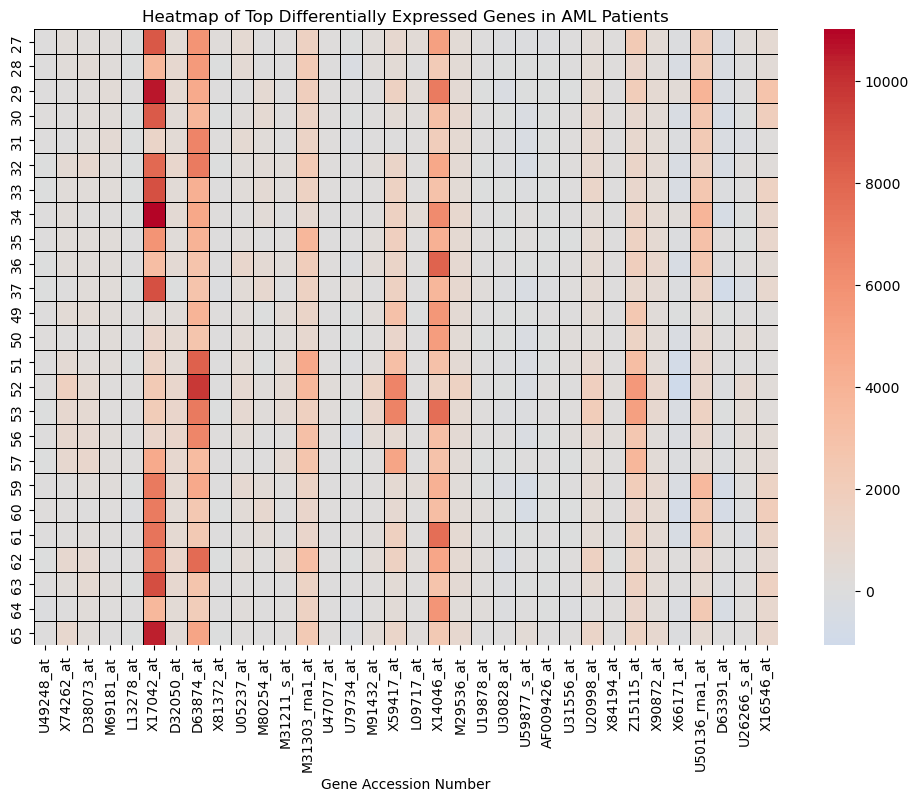

In [113]:
plt.figure(figsize=(12,8))
sns.heatmap(AMLTop,
            cmap="coolwarm",
            center=0,
            linewidth = 0.5,
            linecolor = "black")
plt.title("Heatmap of Top Differentially Expressed Genes in AML Patients")
plt.show()

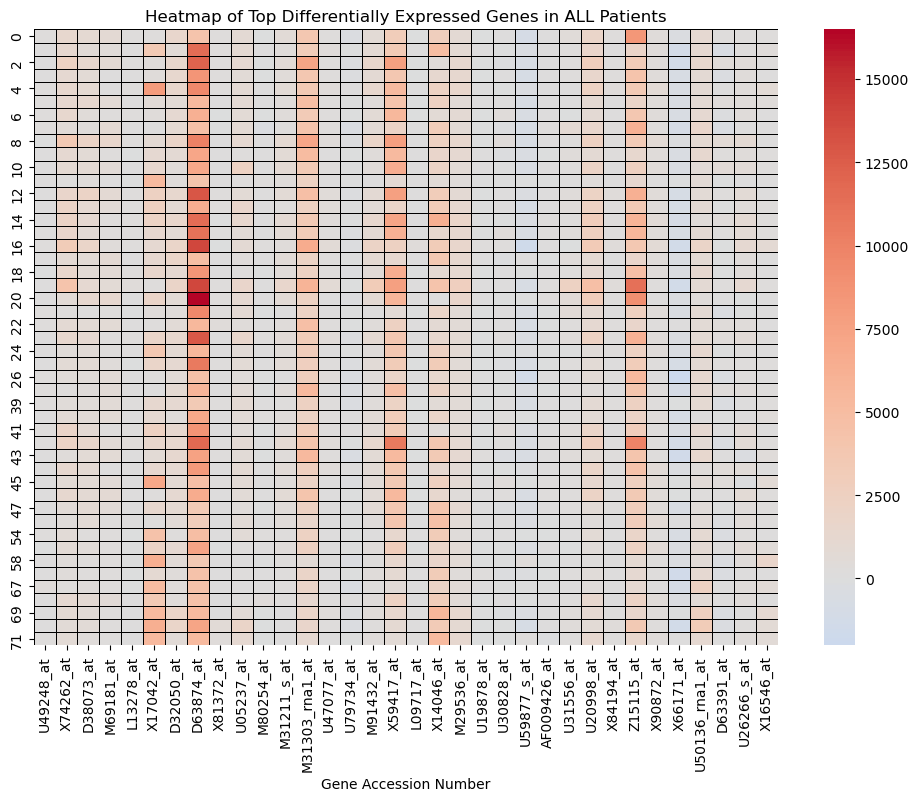

In [114]:
plt.figure(figsize=(12,8))
sns.heatmap(ALLTop,
            cmap="coolwarm",
            center=0,
            linewidth = 0.5,
            linecolor = "black")
plt.title("Heatmap of Top Differentially Expressed Genes in ALL Patients")
plt.show()